<a href="https://colab.research.google.com/github/jpantojaj/DIP-CS_AI/blob/main/Credit_Scoring_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Seguimiento de Nuevas Cosechas**

### **1. Carga Inicial de Librerías**

In [2]:
pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 9.8 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

In [12]:
class CategoricalImputerWithDecoding(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42, max_iter=10):
        self.random_state = random_state
        self.max_iter = max_iter
        self.ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.imputer = IterativeImputer(
            estimator=RandomForestClassifier(random_state=self.random_state),
            max_iter=self.max_iter,
            random_state=self.random_state,
            add_indicator=False
        )
        self.columns_ = None

    def set_output(self, *, transform=None):
        return self

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        self.columns_ = X.columns.tolist()
        X_encoded = self.ordinal_encoder.fit_transform(X)
        self.imputer.fit(X_encoded)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns_)
        X_encoded = self.ordinal_encoder.transform(X)
        X_imputed_encoded = self.imputer.transform(X_encoded)
        X_imputed_decoded = self.ordinal_encoder.inverse_transform(X_imputed_encoded)
        return pd.DataFrame(X_imputed_decoded, columns=self.columns_, index=X.index)

In [13]:
class PowerWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, capping_method='both', lower_percentile=0.01, upper_percentile=0.99):
        self.capping_method = capping_method
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.pt = PowerTransformer(method='yeo-johnson', standardize=True)
        self.columns_ = None
        self.capping_values_ = {}
        self.original_dtypes_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)
        elif not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=[f'col_{i}' for i in range(X.shape[1])])
        self.columns_ = X.columns.tolist()
        self.original_dtypes_ = X.dtypes
        self.pt.fit(X)
        X_transformed = self.pt.transform(X)

        for i, col in enumerate(self.columns_):
            lower_cap = np.percentile(X_transformed[:, i], self.lower_percentile * 100)
            upper_cap = np.percentile(X_transformed[:, i], self.upper_percentile * 100)
            self.capping_values_[col] = {'lower_cap': lower_cap, 'upper_cap': upper_cap}

        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X, columns=self.columns_)
        elif not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns_)
        original_index = X.index
        X_transformed = self.pt.transform(X)
        X_capped_transformed = X_transformed.copy()
        for i, col in enumerate(self.columns_):
            lower_cap = self.capping_values_[col]['lower_cap']
            upper_cap = self.capping_values_[col]['upper_cap']
            if self.capping_method == 'right' or self.capping_method == 'both':
                X_capped_transformed[:, i][X_capped_transformed[:, i] > upper_cap] = upper_cap
            if self.capping_method == 'left' or self.capping_method == 'both':
                X_capped_transformed[:, i][X_capped_transformed[:, i] < lower_cap] = lower_cap

        X_final = self.pt.inverse_transform(X_capped_transformed)
        X_final_df = pd.DataFrame(X_final, columns=self.columns_, index=original_index)
        for col in X_final_df.columns:
            if col in self.original_dtypes_.index:
                X_final_df[col] = X_final_df[col].astype(self.original_dtypes_[col])

        return X_final_df

    def set_output(self, *, transform=None):
        return self

### **2. Carga y Análisis inicial de datos**

In [14]:
df_nc = pd.read_csv('Base_SolicitudesCreditoEfectivo_NuevasCosechas.csv', sep = ",")
df_nc.head()

,CODMES,CODSOLICITUD,DEUDA,PLAZO_CREDITO,FLG_GARANTIA,MIN_MES_DE_DEFAULT,FLG_DEFAULT_12M,SEGMENTOCLIENTE,TARJETA_RELACIONADA,VEHICULAR_RELACIONADA,...,INGRESO_CLIENTE,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL,EDAD_T,CUOTA,LINEA_DE_TC,MONTO_TC_MEMBRESIA,FLG_TC_VISA,FLG_TC_MC
0,201506,18146,1492.857333,36,0,NaN,0,CLIENTES SIGNATURE,1,0,...,1076.761626,TECNICO,JUNIN,CON,29.0,86.667240,842.0,60.0,0.0,0.0
1,201506,18162,8153.666857,60,0,NaN,0,CLIENTES PLATINUM SEGM 2,0,0,...,7239.348312,INGENIERO,LIMA_SUR,CAS,29.0,1396.311126,7930.0,157.0,1.0,1.0
2,201506,18168,23325.895830,60,0,NaN,0,CLIENTES PLATINUM SEGM 2,1,0,...,5115.384021,TECNICO,ANCASH,SOL,32.0,90.223329,20100.0,170.0,0.0,0.0
3,201506,18181,10743.241170,48,0,NaN,0,CLIENTES ORO,0,0,...,2178.714693,INGENIERO DE SISTEMAS,AREQUIPA,SOL,37.0,1676.799222,1679.0,136.0,1.0,1.0
4,201506,18196,2665.816667,36,0,NaN,0,CLIENTES ORO,1,0,...,1299.634324,PROFESOR,LIMA_NORTE,SOL,32.0,47.049240,900.0,60.0,0.0,0.0


In [15]:
df_ref = pd.read_csv('Base_SolicitudesCreditoEfectivo_Test.csv', sep = ",", index_col=False)
df_ref.head()

,CODMES,CODSOLICITUD,DEUDA,PLAZO_CREDITO,FLG_GARANTIA,MIN_MES_DE_DEFAULT,SEGMENTOCLIENTE,TARJETA_RELACIONADA,VEHICULAR_RELACIONADA,HIPOTECARIO_RELACIONADA,...,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL,EDAD_T,CUOTA,LINEA_DE_TC,MONTO_TC_MEMBRESIA,FLG_TC_VISA,FLG_TC_MC,FLG_DEFAULT_12M
0,201402,10380,5927.368333,24,0,NaN,CLIENTES PLATINUM SEGM 2,1,0,0,...,ECONOMISTA,LIMA_MODERNA,SOL,32.0,1508.99364,30000.0,350.0,0.0,0.0,0
1,201406,18075,1076.656667,12,0,NaN,CLIENTES ORO,1,0,0,...,TECNICO,JUNIN,SOL,30.0,151.06791,15500.0,60.0,0.0,0.0,0
2,201311,1450,2685.572044,48,0,201405.0,CLIENTES ORO,1,0,0,...,ADMINISTRADOR,LIMA_ESTE,SOL,27.0,5.46000,500.0,60.0,0.0,0.0,1
3,201310,11242,4310.813333,24,0,NaN,CLIENTES ORO,1,0,0,...,TECNICO,CUZCO,SOL,44.0,251.50104,6290.0,170.0,0.0,0.0,0
4,201405,17106,482.073022,12,0,NaN,CLIENTES ORO,1,0,0,...,TECNICO,PIURA,SOL,24.0,31.93596,1500.0,60.0,0.0,0.0,0


#### Corregimos los tipos de variables, este paso es circunstancial

In [16]:
# Repormateo de algunos campos
df_nc['CODMES']=df_nc['CODMES'].astype(str)
df_nc['CODSOLICITUD']=df_nc['CODSOLICITUD'].astype(str)
df_nc['FLG_GARANTIA']=df_nc['FLG_GARANTIA'].astype(str)
df_nc['TARJETA_RELACIONADA']=df_nc['TARJETA_RELACIONADA'].astype(str)
df_nc['VEHICULAR_RELACIONADA']=df_nc['VEHICULAR_RELACIONADA'].astype(str)
df_nc['HIPOTECARIO_RELACIONADA']=df_nc['HIPOTECARIO_RELACIONADA'].astype(str)
df_nc['CLASIF_SISTEMA_ULT_12M']=df_nc['CLASIF_SISTEMA_ULT_12M'].astype(str)
df_nc['FLG_PDH']=df_nc['FLG_PDH'].astype(str)
df_nc['FLG_TC_VISA']=df_nc['FLG_TC_VISA'].astype(str)
df_nc['FLG_TC_MC']=df_nc['FLG_TC_MC'].astype(str)

# Repormateo de algunos campos
df_ref['CODMES']=df_ref['CODMES'].astype(str)
df_ref['CODSOLICITUD']=df_ref['CODSOLICITUD'].astype(str)
df_ref['FLG_GARANTIA']=df_ref['FLG_GARANTIA'].astype(str)
df_ref['TARJETA_RELACIONADA']=df_ref['TARJETA_RELACIONADA'].astype(str)
df_ref['VEHICULAR_RELACIONADA']=df_ref['VEHICULAR_RELACIONADA'].astype(str)
df_ref['HIPOTECARIO_RELACIONADA']=df_ref['HIPOTECARIO_RELACIONADA'].astype(str)
df_ref['CLASIF_SISTEMA_ULT_12M']=df_ref['CLASIF_SISTEMA_ULT_12M'].astype(str)
df_ref['FLG_PDH']=df_ref['FLG_PDH'].astype(str)
df_ref['FLG_TC_VISA']=df_ref['FLG_TC_VISA'].astype(str)
df_ref['FLG_TC_MC']=df_ref['FLG_TC_MC'].astype(str)

In [17]:
# Eliminación de un campo innecesario
df_nc.drop('MIN_MES_DE_DEFAULT', axis=1, inplace=True)
df_ref.drop('MIN_MES_DE_DEFAULT', axis=1, inplace=True)

In [18]:
# Parche para que se deje en nulo los registros donde tenemos nan
for col in df_nc.select_dtypes(include='object').columns:
    df_nc[col] = df_nc[col].replace('nan', np.nan)

# Parche para que se deje en nulo los registros donde tenemos nan
for col in df_ref.select_dtypes(include='object').columns:
    df_ref[col] = df_ref[col].replace('nan', np.nan)

#### Como se ve nuestra muestra de referencia

# Buen_Pagador: 8977
# 1 Mora_12M: 607
Bad rate: 0.0633347245409015


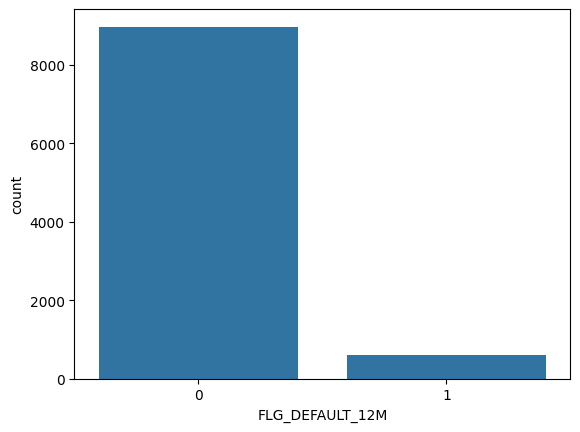

In [21]:
sns.countplot(data = df_ref, x = "FLG_DEFAULT_12M")
target_count = df_ref.FLG_DEFAULT_12M.value_counts()
print('# Buen_Pagador:', target_count[0])
print('# 1 Mora_12M:', target_count[1])
print('Bad rate:', target_count[1]/(target_count[0]+target_count[1]))

<Axes: xlabel='CODMES'>

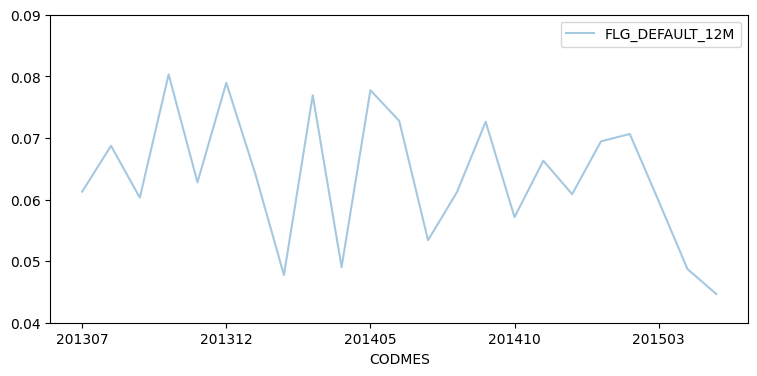

In [22]:
a2=df_ref.pivot_table(values="FLG_DEFAULT_12M", index="CODMES", aggfunc="mean", sort=True)
a2.plot(alpha = 0.4, figsize=(9,4), ylim=(0.04,0.09))

####  Como se ve la nueva muestra

# Buen_Pagador: 8423
# 1 Mora_12M: 550
Bad rate: 0.06129499609940934


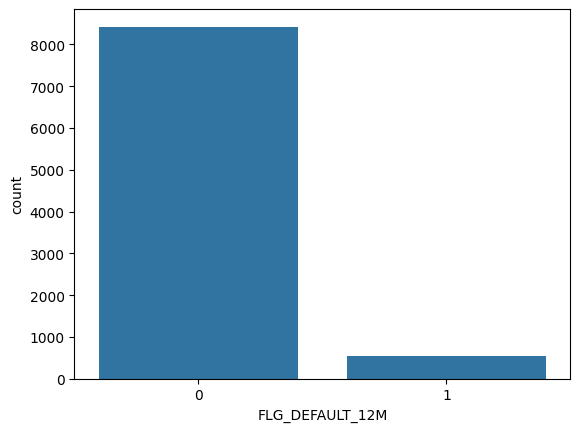

In [23]:
sns.countplot(data = df_nc, x = "FLG_DEFAULT_12M")
target_count = df_nc.FLG_DEFAULT_12M.value_counts()
print('# Buen_Pagador:', target_count[0])
print('# 1 Mora_12M:', target_count[1])
print('Bad rate:', target_count[1]/(target_count[0]+target_count[1]))

<Axes: xlabel='CODMES'>

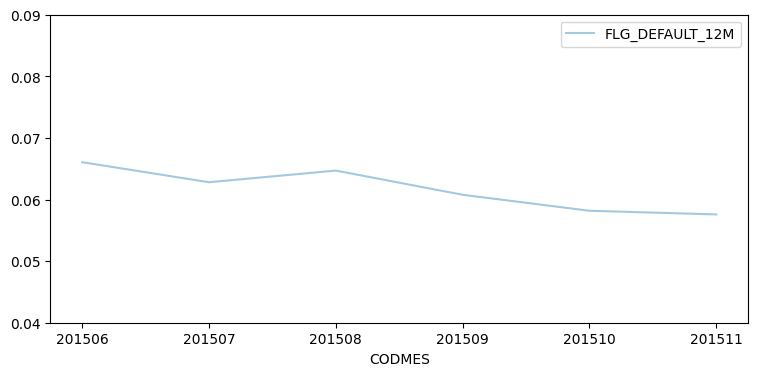

In [24]:
a2=df_nc.pivot_table(values="FLG_DEFAULT_12M", index="CODMES", aggfunc="mean", sort=True)
a2.plot(alpha = 0.4, figsize=(9,4), ylim=(0.04,0.09))

### **3. Carga de los artefactos desarrollados en el entrenamiento**

#### En esta parte, llamamos a los pickles del Feature Engineering como del Modelo Final para su uso

In [25]:
import pickle

In [26]:
# Cargar el pipeline del feature engineering
with open('fe_pipeline.pkl','rb') as fe_data_file:
     fe_final = pickle.load(fe_data_file)

In [27]:
# Cargar el modelo
with open('final_model.pkl','rb') as modelFile:
     modelo_final = pickle.load(modelFile)

### Con lo anterior apliquemos los pickles a nuestras muestras

In [28]:
#Probemos el pipeline
df_ref_xt=fe_final.transform(df_ref.drop(['FLG_DEFAULT_12M'],axis=1))
df_nc_xt=fe_final.transform(df_nc.drop(['FLG_DEFAULT_12M'],axis=1))
df_ref_y=df_ref['FLG_DEFAULT_12M']
df_nc_y=df_nc['FLG_DEFAULT_12M']

In [29]:
tot_df_ref_xt=pd.concat([df_ref_xt, df_ref_y],axis=1)
tot_df_nc_xt=pd.concat([df_nc_xt, df_nc_y],axis=1)

### **4. ROC - GINI**

#### Primero, evaluemos el poder predictivo del modelo en la nueva muestra, comparado con las métricas obtenidas en la muestra de referencia (test)

In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
# Probemos el modelo
pred_ref = modelo_final.predict_proba(df_ref_xt)
pred_nc = modelo_final.predict_proba(df_nc_xt)
print('BaseLine roc-auc: ',roc_auc_score(df_ref_y, pred_ref[:,1]), 'GINI: ', 2*roc_auc_score(df_ref_y, pred_ref[:,1])-1 )
print('New roc-auc: ', roc_auc_score(df_nc_y, pred_nc[:,1]), 'GINI: ', 2*roc_auc_score(df_nc_y, pred_nc[:,1])-1 )

BaseLine roc-auc:  0.7680413922528357 GINI:  0.5360827845056715
New roc-auc:  0.7878168003194714 GINI:  0.5756336006389429


#### Podemos complementar este análisis con un Bootstrapping de la muestra nueva, para ver si el GINI inicial se encuentra dentro de los posibles valores generados

In [32]:
from sklearn.utils import resample

In [33]:
bootstrap_iter = 50
roc_auc = []

In [34]:
for i in range(bootstrap_iter):
    X_, y_ = resample(df_nc_xt, df_nc_y)
    y_pred = modelo_final.predict_proba(X_)
    acc = roc_auc_score(y_,y_pred[:,1])
    roc_auc.append(acc)

In [35]:
roc_auc_final = np.array(roc_auc)

In [36]:
roc_auc_final

array([0.78547664, 0.78562468, 0.80730883, 0.78446245, 0.78988061,
       0.80253022, 0.79202011, 0.78264188, 0.78954222, 0.80638375,
       0.79151807, 0.77115175, 0.77173169, 0.80074605, 0.7961124 ,
       0.78844322, 0.80851852, 0.76698488, 0.78737295, 0.79482063,
       0.78610473, 0.81668641, 0.79623905, 0.79739474, 0.80371483,
       0.79186896, 0.78948061, 0.79608985, 0.80383044, 0.79931471,
       0.78428483, 0.79543539, 0.77858287, 0.79196425, 0.78457447,
       0.78112493, 0.7911378 , 0.80031263, 0.77891748, 0.77928197,
       0.75805699, 0.78185007, 0.7768011 , 0.79934902, 0.78176802,
       0.78874678, 0.79421385, 0.79636131, 0.77959563, 0.76958503])

In [37]:
gini_final=2*roc_auc_final-1

In [38]:
gini_final

array([0.57095328, 0.57124936, 0.61461766, 0.5689249 , 0.57976121,
       0.60506044, 0.58404022, 0.56528375, 0.57908443, 0.61276749,
       0.58303615, 0.54230351, 0.54346337, 0.6014921 , 0.5922248 ,
       0.57688643, 0.61703703, 0.53396975, 0.5747459 , 0.58964127,
       0.57220947, 0.63337283, 0.5924781 , 0.59478948, 0.60742967,
       0.58373793, 0.57896122, 0.5921797 , 0.60766088, 0.59862942,
       0.56856967, 0.59087078, 0.55716573, 0.58392849, 0.56914894,
       0.56224987, 0.5822756 , 0.60062526, 0.55783496, 0.55856394,
       0.51611397, 0.56370014, 0.5536022 , 0.59869804, 0.56353604,
       0.57749356, 0.58842769, 0.59272262, 0.55919126, 0.53917007])

In [39]:
print('GINI')
print('Average: ', gini_final.mean())
print('Standard deviation: ', gini_final.std())

GINI
Average:  0.5790376110310675
Standard deviation:  0.022926604760956676


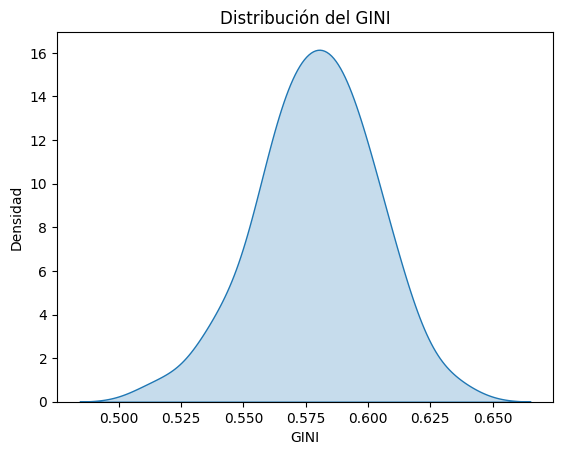

In [40]:
sns.kdeplot(gini_final, shade=True)
plt.title('Distribución del GINI')
plt.xlabel('GINI')
plt.ylabel('Densidad')
plt.show()

In [41]:
#bandas de confianza
from scipy.stats import norm
z_value = norm.ppf((1 + 0.99) / 2)

In [42]:
LS=gini_final.mean()+z_value*gini_final.std()
LS

np.float64(0.6380926314052234)

In [43]:
LI=gini_final.mean()-z_value*gini_final.std()
LI

np.float64(0.5199825906569117)

#### Luego, también es importante verificar como se ve el poder discriminatorio de cada variable en la nueva muestra vs el baseline (referencia)

In [44]:
# Función para calcular el ROC AUC de cada variable
def calcular_gini(df, target):
    gini = {}
    for col in df.columns:
        if col != target:
            try:
                gini[col] = 2*roc_auc_score(df[target], df[col])-1
            except:
                gini[col] = np.nan  # Si la variable tiene solo un valor, se pone NaN
    return gini

In [45]:
gini_ref = calcular_gini(tot_df_ref_xt, 'FLG_DEFAULT_12M')
gini_nc = calcular_gini(tot_df_nc_xt, 'FLG_DEFAULT_12M')

In [46]:
df_gini = pd.DataFrame({'Gini_Ref': gini_ref, 'Gini_NC': gini_nc})
df_gini['Diferencia'] = df_gini['Gini_NC'] - df_gini['Gini_Ref']

In [47]:
df_gini

,Gini_Ref,Gini_NC,Diferencia
NUMERO_DE_PAGOS_PDH,-0.250335,-0.240172,0.010163
ATRASO_MAXIMO_ULT_24M,0.064817,0.067147,0.002329
MESES_AHORROS_ULT_6M,-0.221657,-0.242363,-0.020705
EDAD_T,-0.153754,-0.136762,0.016992
PLAZO_CREDITO,0.125526,0.110012,-0.015513
...,...,...,...
ESTADO_CIVIL_CBS,-0.000094,0.001849,0.001943
ESTADO_CIVIL_CON,0.001993,-0.000614,-0.002607
ESTADO_CIVIL_SEP,-0.007382,-0.007337,0.000045
ESTADO_CIVIL_SOL,0.105239,0.097644,-0.007594


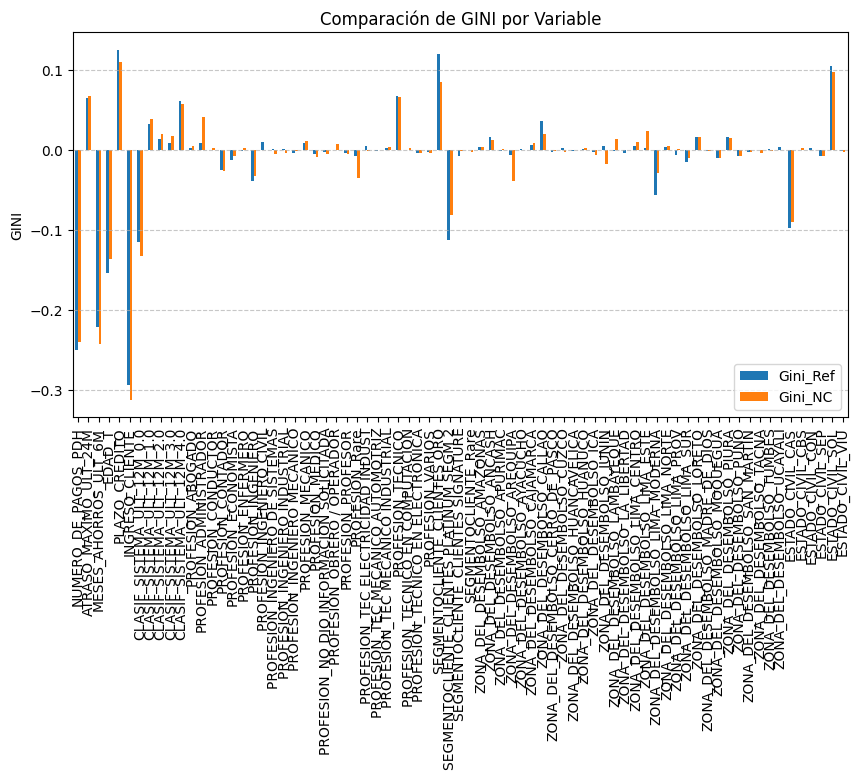

In [48]:
df_gini[['Gini_Ref', 'Gini_NC']].plot(kind='bar', figsize=(10, 5), title="Comparación de GINI por Variable")
plt.ylabel("GINI")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **5. PSI y CSI**

#### EL PSI (Population Stability Index) busca medir la estabilidad de la población basado en la comparación de la distribución por rangos fijos o percentilicos, a partir de un baseline o muestra de referencia

In [49]:
pd.DataFrame(pred_ref[:,1]).describe()

,0
count,9584.000000
mean,0.063434
std,0.066677
min,0.001035
25%,0.020498
50%,0.041557
75%,0.082672
max,0.697316


In [50]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [51]:
buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = scale_range(raw_breakpoints, np.min(pred_ref[:,1]), np.max(pred_ref[:,1]))

In [52]:
initial_counts = np.histogram(pred_ref[:,1], breakpoints)[0]
new_counts = np.histogram(pred_nc[:,1], breakpoints)[0]

In [53]:
df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / len(pred_ref[:,1])
df['New Percent'] = df['New Count'] / len(pred_nc[:,1])

In [54]:
df['New Percent'][df['New Percent'] == 0] = 0.001

In [55]:
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent
0,1,0.070663,6708,6487,0.699917,0.722947
1,2,0.140291,1887,1665,0.196891,0.185557
2,3,0.209919,596,494,0.062187,0.055054
3,4,0.279547,228,186,0.023790,0.020729
4,5,0.349175,97,78,0.010121,0.008693
5,6,0.418803,38,30,0.003965,0.003343
6,7,0.488431,15,18,0.001565,0.002006
7,8,0.558060,8,8,0.000835,0.000892
8,9,0.627688,5,3,0.000522,0.000334
9,10,0.697316,2,2,0.000209,0.000223


In [56]:
percents = df[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

In [57]:
percents

,Bucket,Population,Percent
0,1,Initial Percent,0.699917
1,2,Initial Percent,0.196891
2,3,Initial Percent,0.062187
3,4,Initial Percent,0.023790
4,5,Initial Percent,0.010121
5,6,Initial Percent,0.003965
6,7,Initial Percent,0.001565
7,8,Initial Percent,0.000835
8,9,Initial Percent,0.000522
9,10,Initial Percent,0.000209


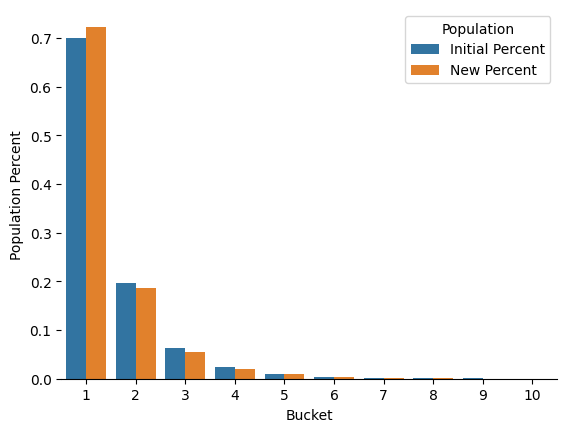

In [58]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [59]:
df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'])

In [60]:
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent,PSI
0,1,0.070663,6708,6487,0.699917,0.722947,7.455831e-04
1,2,0.140291,1887,1665,0.196891,0.185557,6.719710e-04
2,3,0.209919,596,494,0.062187,0.055054,8.690058e-04
3,4,0.279547,228,186,0.023790,0.020729,4.215450e-04
4,5,0.349175,97,78,0.010121,0.008693,2.172818e-04
5,6,0.418803,38,30,0.003965,0.003343,1.059877e-04
6,7,0.488431,15,18,0.001565,0.002006,1.094322e-04
7,8,0.558060,8,8,0.000835,0.000892,3.744270e-06
8,9,0.627688,5,3,0.000522,0.000334,8.336884e-05
9,10,0.697316,2,2,0.000209,0.000223,9.360675e-07


In [61]:
sum(df['PSI'])

0.0032288557526675755

#### Según este valor, no observamos una variación significativa en las poblaciones de referencia y nueva

#### Seteamos una función para calcular el PSI y CSI

In [62]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    def psi(expected_array, actual_array, buckets):
        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [63]:
calculate_psi(pred_ref[:,1], pred_nc[:,1], buckettype='bins', buckets=10, axis=0)

np.float64(0.0032288557526675777)

In [64]:
calculate_psi(pred_ref[:,1], pred_nc[:,1], buckettype='quantiles', buckets=10, axis=0)

np.float64(0.0035958840281910035)

#### EL CSI (Characteristic Stability Index) es similar al PSI pero sobre las distribuciones de cada variable

In [65]:
# Rangos Fijos
print("CSI - Rangos Fijos")
for col in df_ref_xt.columns:
    csi_values = calculate_psi(df_ref_xt[col].values, df_nc_xt[col].values, buckettype='bins', buckets=10, axis=0)
    csi = np.sum(csi_values)
    print(f'{col} -> {csi=:.4f}')

CSI - Rangos Fijos
NUMERO_DE_PAGOS_PDH -> csi=0.0044
ATRASO_MAXIMO_ULT_24M -> csi=0.0012
MESES_AHORROS_ULT_6M -> csi=0.0049
EDAD_T -> csi=0.0010
PLAZO_CREDITO -> csi=0.0045
INGRESO_CLIENTE -> csi=0.0017
CLASIF_SISTEMA_ULT_12M_0.0 -> csi=0.0006
CLASIF_SISTEMA_ULT_12M_1.0 -> csi=0.0013
CLASIF_SISTEMA_ULT_12M_2.0 -> csi=0.0000
CLASIF_SISTEMA_ULT_12M_3.0 -> csi=0.0006
CLASIF_SISTEMA_ULT_12M_4.0 -> csi=0.0000
PROFESION_ABOGADO -> csi=0.0000
PROFESION_ADMINISTRADOR -> csi=0.0001
PROFESION_CONDUCTOR -> csi=0.0000
PROFESION_CONTADOR -> csi=0.0004
PROFESION_ECONOMISTA -> csi=0.0000
PROFESION_ENFERMERO -> csi=0.0000
PROFESION_INGENIERO -> csi=0.0000
PROFESION_INGENIERO CIVIL -> csi=0.0000
PROFESION_INGENIERO DE SISTEMAS -> csi=0.0000
PROFESION_INGENIERO INDUSTRIAL -> csi=0.0005
PROFESION_INGENIERO MECANICO -> csi=0.0003
PROFESION_MECANICO -> csi=0.0002
PROFESION_MEDICO -> csi=0.0000
PROFESION_NO DIO INFORMACION SOLICITADA -> csi=0.0002
PROFESION_OBRERO / OPERADOR -> csi=0.0000
PROFESION_PROFESOR

In [66]:
# Rangos Percentílicos
print("CSI - Rango Percentílicos")
for col in df_ref_xt.columns:
    csi_values = calculate_psi(df_ref_xt[col].values, df_nc_xt[col].values, buckettype='quantile', buckets=10, axis=0)
    csi = np.sum(csi_values)
    print(f'{col} -> {csi=:.4f}')

CSI - Rango Percentílicos
NUMERO_DE_PAGOS_PDH -> csi=0.0001
ATRASO_MAXIMO_ULT_24M -> csi=0.0003
MESES_AHORROS_ULT_6M -> csi=0.0005
EDAD_T -> csi=0.0002
PLAZO_CREDITO -> csi=0.0004
INGRESO_CLIENTE -> csi=0.0004
CLASIF_SISTEMA_ULT_12M_0.0 -> csi=0.0000
CLASIF_SISTEMA_ULT_12M_1.0 -> csi=0.0000
CLASIF_SISTEMA_ULT_12M_2.0 -> csi=0.0000
CLASIF_SISTEMA_ULT_12M_3.0 -> csi=0.0000
CLASIF_SISTEMA_ULT_12M_4.0 -> csi=0.0000
PROFESION_ABOGADO -> csi=0.0000
PROFESION_ADMINISTRADOR -> csi=0.0000
PROFESION_CONDUCTOR -> csi=0.0000
PROFESION_CONTADOR -> csi=0.0000
PROFESION_ECONOMISTA -> csi=0.0000
PROFESION_ENFERMERO -> csi=0.0000
PROFESION_INGENIERO -> csi=0.0000
PROFESION_INGENIERO CIVIL -> csi=0.0000
PROFESION_INGENIERO DE SISTEMAS -> csi=0.0000
PROFESION_INGENIERO INDUSTRIAL -> csi=0.0000
PROFESION_INGENIERO MECANICO -> csi=0.0000
PROFESION_MECANICO -> csi=0.0000
PROFESION_MEDICO -> csi=0.0000
PROFESION_NO DIO INFORMACION SOLICITADA -> csi=0.0000
PROFESION_OBRERO / OPERADOR -> csi=0.0000
PROFESION_P

### **6. Calibración**

#### Veamos rápidamente la PD Promedio vs la RD de la nueva muestra

In [67]:
print('La PD Promedio Baseline es: ', pred_ref[:,1].mean(), 'El RD Baseline es de: ', df_ref_y.mean())

La PD Promedio Baseline es:  0.06343439028391622 El RD Baseline es de:  0.0633347245409015


In [68]:
print('La PD Promedio Nueva es: ', pred_nc[:,1].mean(), 'El RD Nueva es de: ', df_nc_y.mean())

La PD Promedio Nueva es:  0.060235338051016496 El RD Nueva es de:  0.06129499609940934


In [69]:
from sklearn.calibration import calibration_curve
# Una función para evaluar la calibración
def plot_calibration_curve(y_true, probs, bins, strategy):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy=strategy)

    max_val = max(mean_predicted_value)

    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label='PD vs RD')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')

    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=True, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

#### Como se ve en la muestra inicial o de test

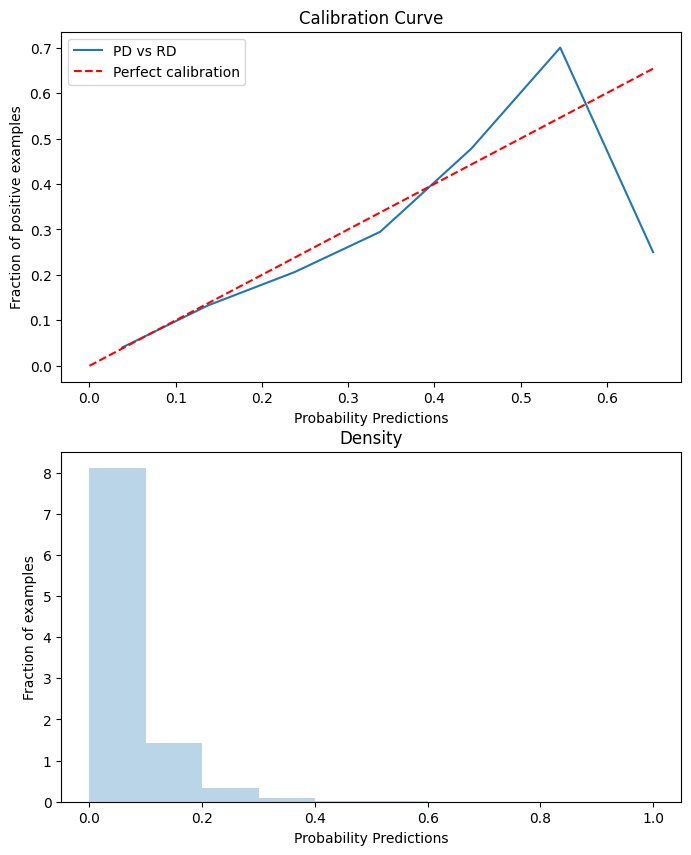

In [70]:
plot_calibration_curve(df_ref_y, pred_ref[:, 1], bins=10, strategy='uniform')

#### Como se ve en la nueva cosecha

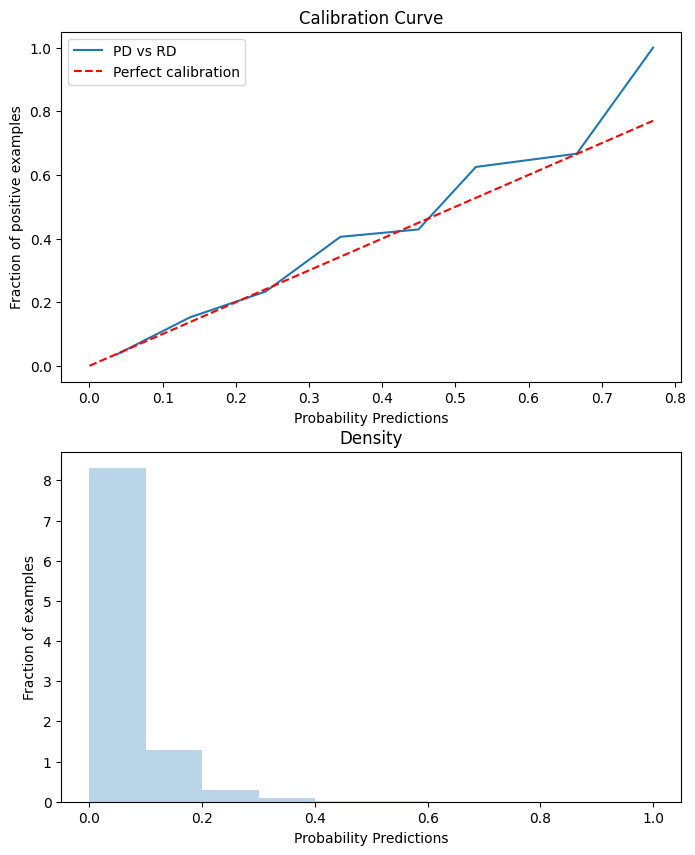

In [71]:
plot_calibration_curve(df_nc_y, pred_nc[:, 1], bins=10, strategy='uniform')

In [72]:
from sklearn.calibration import CalibratedClassifierCV

In [73]:
# Calibración Sigmoide
cal_sigmoid = CalibratedClassifierCV(modelo_final, cv='prefit', method='sigmoid')
cal_sigmoid.fit(df_nc_xt, df_nc_y)
prob_sigmoid = cal_sigmoid.predict_proba(df_nc_xt)[:, 1]

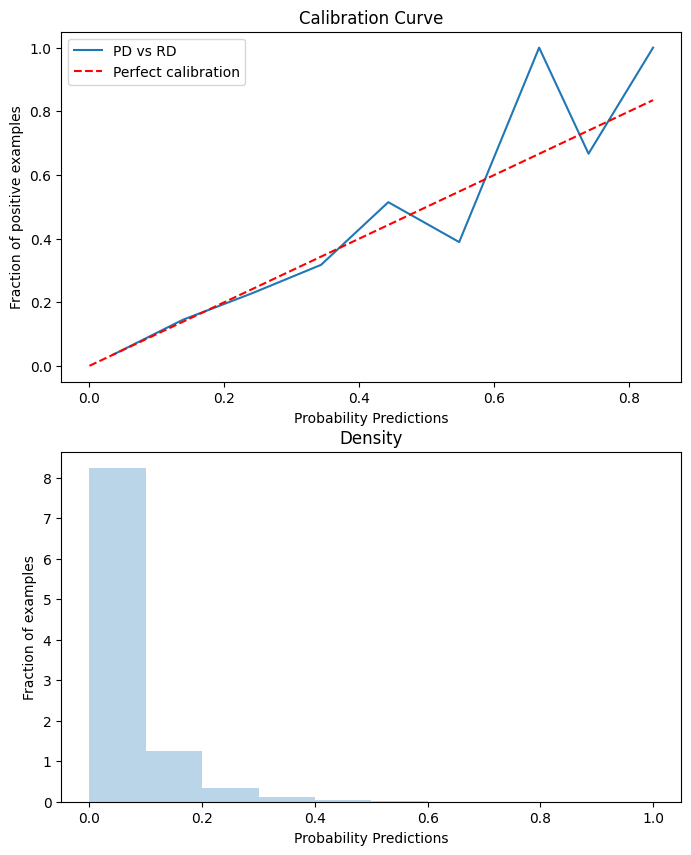

In [74]:
plot_calibration_curve(df_nc_y, prob_sigmoid, bins=10, strategy='uniform')

In [75]:
prob_sigmoid

array([0.02609722, 0.01098119, 0.03449783, ..., 0.02061339, 0.01796981,
       0.02862483])

In [76]:
print('La PD Promedio Nueva es: ', prob_sigmoid.mean(), 'El RD Nueva es de: ', df_nc_y.mean())

La PD Promedio Nueva es:  0.061295373471327 El RD Nueva es de:  0.06129499609940934
